In [160]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal, interpolate
import copy
import os 
import pandas as pd
from tqdm import tqdm

from pyCompare._plotBlandAltman import blandAltman  
from sklearn.metrics import cohen_kappa_score
from bishop_peaks_onsets import *
os.chdir('/home/kkotzen/research/PPG_sleepstaging_orion3/')
from pathlib import Path
from src.parsing.MESAParser import MESAParser
from src.parsing.CFSParser import CFSParser
from src.parsing.UHVParser import UHVParser
from src.parsing.SHHSParser import SHHSParser


from src.datasets.mesa_dataset import MESA_Dataset
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Database Metrics

In [36]:
sleep_stages = {0:"Wake", 1:"Light", 2:"Light", 3:"Deep", 4:"REM"}
def database_metrics(dl):
    metadata = dl.metadata
    patients = dl.database_all_patient_IDs
    df_mesa = pd.DataFrame()
    length = 0
    for patient in tqdm.tqdm(patients):
        sleep = dl.load_sleep(patient)
        L = min(1200,len(sleep))
        sleep = sleep[0:L]
        length = length+len(sleep)/120
        sleep[sleep>4] = 0
        sleep = np.array([sleep_stages[s] for s in sleep])
        stage, count = np.unique(sleep, return_counts=True)

        age = metadata[metadata.id==patient].age.values[0]
        ahi = metadata[metadata.id==patient].ahi.values[0]

        df_mesa = df_mesa.append({"Length":len(sleep), "Age":age ,"AHI":ahi,**{s:int(c*100) for s,c in zip(stage,count/sum(count))}}, ignore_index=True)
    
    print(f"Patient Count: {len(patients)}")
    print(f"Total Duration: {length}")
    print(f"Average Duration: {length/len(patients)}")
    df_mesa[['Light Frac', 'Deep Frac', 'REM Frac']] =df_mesa[['Light', 'Deep', 'REM']].sum()/(df_mesa[['Light', 'Deep', 'REM']].sum().sum())
    display(df_mesa[["Length", "Age", "AHI", "Wake", "Light Frac", "Deep Frac", "REM Frac"]].describe().astype(int))
    
    describe =  df_mesa[["Length", "Age", "AHI", "Wake", "Light Frac", "Deep Frac", "REM Frac"]].describe().astype(int)
    describe = describe.T
    describe['IQR'] = describe["75%"] - describe["25%"]
    return describe.T

    
print("-----------------SHHS-------------------")
shhs = database_metrics(SHHSParser())
print("-----------------MESA-------------------")
mesa = database_metrics(MESAParser())
print("-----------------CFS-------------------")
cfs = database_metrics(CFSParser())

-----------------SHHS-------------------


100%|████████████████████████████████████████████████████████████████| 5758/5758 [00:47<00:00, 120.56it/s]


Patient Count: 5758
Total Duration: 48565.29166666793
Average Duration: 8.434402859789499


,Length,Age,AHI,Wake,Light Frac,Deep Frac,REM Frac
count,5758,5758,5758,5758,5758,5758,5758
mean,1012,63,14,28,0,0,0
std,74,11,14,12,0,0,0
min,360,39,0,1,0,0,0
25%,960,55,3,19,0,0,0
50%,1051,63,9,27,0,0,0
75%,1056,72,18,35,0,0,0
max,1086,90,161,91,0,0,0


-----------------MESA-------------------


100%|█████████████████████████████████████████████████████████████████| 2054/2054 [00:21<00:00, 96.75it/s]

Patient Count: 2054
Total Duration: 19998.20833333315
Average Duration: 9.73622606296648


,Length,Age,AHI,Wake,Light Frac,Deep Frac,REM Frac
count,2054,2054,2053,2054,2054,2054,2054
mean,1168,69,19,38,0,0,0
std,56,9,18,13,0,0,0
min,698,54,0,5,0,0,0
25%,1139,62,5,30,0,0,0
50%,1200,68,13,37,0,0,0
75%,1200,76,27,47,0,0,0
max,1200,94,110,94,0,0,0


-----------------CFS-------------------


100%|██████████████████████████████████████████████████████████████████| 320/320 [00:02<00:00, 130.51it/s]

Patient Count: 320
Total Duration: 3057.5499999999997
Average Duration: 9.55484375


,Length,Age,AHI,Wake,Light Frac,Deep Frac,REM Frac
count,320,320,11,320,320,320,320
mean,1146,39,16,35,0,0,0
std,76,19,12,12,0,0,0
min,614,7,0,6,0,0,0
25%,1114,21,5,27,0,0,0
50%,1180,42,14,34,0,0,0
75%,1200,54,26,44,0,0,0
max,1200,88,35,78,0,0,0


In [34]:
shhs_ = shhs.T
mesa_ = mesa.T
cfs_ = cfs.T

for i in shhs_.index:
    print(f"{i} & \
          {shhs_['50%'][i]} [{shhs_['25%'][i]}-{shhs_['75%'][i]}] & \
          {mesa_['50%'][i]} [{mesa_['25%'][i]}-{mesa_['75%'][i]}] & \
          {cfs_['50%'][i]} [{cfs_['25%'][i]}-{cfs_['75%'][i]}]\\\\")


Length &           1051 [960-1056] &           1200 [1139-1200] &           1180 [1114-1200]\\
Age &           63 [55-72] &           68 [62-76] &           42 [21-54]\\
AHI &           9 [3-18] &           13 [5-27] &           14 [5-26]\\
Wake &           27 [19-35] &           37 [30-47] &           34 [27-44]\\
Light &           44 [36-52] &           43 [36-50] &           39 [29-46]\\
Deep &           12 [6-18] &           5 [1-10] &           12 [7-19]\\
REM &           14 [10-17] &           11 [7-14] &           11 [8-14]\\


# Plot FE, DTS, WAV waveforms

In [40]:
wav_path = f"/home/kkotzen/tmp/PPG_WAV_CFS.pkl"
dts_path = f"/home/kkotzen/tmp/IPR_CFS.pkl"
fe_path = f"/home/kkotzen/tmp/PRV_CFS.pkl"

wav = pickle.load(open(wav_path, "rb"))
dts = pickle.load(open(dts_path, "rb"))
fe = pickle.load(open(fe_path, "rb"))

In [43]:
plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(10,3))
w = wav['800032'].signal[128]
ax.plot(np.arange(0, len(w)/34, 1/34), w, linewidth=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Time (seconds)", size=18)
ax.set_ylabel("PPG (N/A)", size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('/home/kkotzen/images/sleep_paper/ppg-waveform.pdf')  

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [44]:
plt.close('all')
fig, ax = plt.subplots(1,1, figsize=(10,3))
w = dts['800032'].signal[128]
ax.plot(np.arange(0, len(w)/(64/30), 1/(64/30)), w, linewidth=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("Time (seconds)", size=18)
ax.set_ylabel("IPR (N/A)", size=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('/home/kkotzen/images/sleep_paper/ppg-dts.pdf')  

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
plt.close('all')
# fig, ax = plt.subplots(1,1, figsize=(10,3))
w = fe['800032'].drop(columns=['sleep', 'patient']).iloc[128]
cols = fe['800032'].drop(columns=['sleep', 'patient', 'epoch']).columns
for i, col in enumerate(cols):
    print(cols[i], ',', w[i])
# ax.plot(np.arange(0, len(w)/(64/30), 1/(64/30)), w)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.set_xlabel("Time (seconds)", size=12)
# ax.set_ylabel("Standardized IPR", size=12)
# plt.tight_layout()
# plt.savefig('/home/kkotzen/images/sleep_paper/ppg-dts.pdf')  

In [49]:
dl = MESAParser()
metadata = dl.metadata
# patients = dl.database_all_patient_IDs
# sleep = {patient:dl.load_sleep(patient) for patient in patients}

In [50]:
[r for r in metadata.columns if 'smok' in r]

[]

In [169]:
probs_file = "/home/kkotzen/tmp/results/66c27d8a81ee4a1e87ee3a4f8b0a14b8.pkl"
predictions = pickle.load(open(probs_file, "rb"))
sleep_predictions = {patient:predictions["predictions"][i] for i,patient in enumerate(predictions['patients'])}
sleep_labels = {patient:predictions["labels"][i] for i,patient in enumerate(predictions['patients'])}
sleep_encoding =  {0: 0, 1: 1, 2: 1, 3: 2, 4: 3, 9:0}

In [172]:
df = pd.DataFrame()
for patient in tqdm.tqdm(sleep_predictions.keys()):

    ss = sleep_labels[patient]
    ss_pred = sleep_predictions[patient]
    kappa = cohen_kappa_score(ss, ss_pred)
    
    arousals = np.sum([1 for i in range(len(ss)-1) if ss[i+1]<ss[i]])
    arousals_pred = np.sum([1 for i in range(len(ss_pred)-1) if ss_pred[i+1]<ss_pred[i]])
    
#     waso = np.sum(ss[np.where(ss > 0)[0]:np.where(ss > 0)[-1]] > 0
#     waso_pred = 
    
    sex = metadata[metadata.id==patient].sex.values[0]
    age = metadata[metadata.id==patient].age.values[0]

    beta = max(metadata[metadata.id==patient].beta5c.values[0],metadata[metadata.id==patient].betad5c.values[0]) 
    anti_arr = metadata[metadata.id==patient].anara5c.values[0]

    ahi = metadata[metadata.id==patient].ahi.values[0]
    hypertension = metadata[metadata.id==patient].htn5c.values[0]
    diabetic_cat = metadata[metadata.id==patient].dm035c.values[0]
    bmi_cat =  metadata[metadata.id==patient].bmicat5c.values[0]
    insomnia = metadata[metadata.id==patient].insmnia5.values[0]
    apnea = metadata[metadata.id==patient].slpapnea5.values[0]
    race = metadata[metadata.id==patient].race1c_x.values[0]
    smoker = metadata[metadata.id==patient].smkstat5.values[0]
    
    df = df.append({'ID':patient, 'Kappa': kappa,'Gender':sex,"Age":age, 'Race':race, "Smoker": smoker,
                    "Beta Blockers":beta, "Anti Arrythmia": anti_arr,
                    'AHI':ahi, "Hypertension":hypertension, 
                    "Diabetes Category": diabetic_cat, "BMI Category": bmi_cat,
                    "Insomnia": insomnia, 'Apnea':apnea,
                    "Wake": len(ss[ss==0]),"Light": len(ss[ss==1]),"Deep":len(ss[ss==2]),"REM": len(ss[ss==3]), 
                    "Wake_Pred": len(ss_pred[ss_pred==0]),"Light_Pred": len(ss_pred[ss_pred==1]),"Deep_Pred":len(ss_pred[ss_pred==2]),"REM_Pred": len(ss_pred[ss_pred==3]), 
                    "Arousals": arousals, "Arousals_Pred": arousals_pred},ignore_index=True)


def smoker_simplify(x):
    if x == 0:
        return 0
    if x == 1:
        return 1
    if x == 2:
        return 1
    if x == 3:
        return 1
    
def age_categories(x):
    if x <=60:
        return 0
    if x > 60 and x <= 65:
        return 1
    if x > 65 and x <= 70:
        return 2
    if x > 70:
        return 3
    
def ahi_categories(x):
    if x <=5:
        return 0
    if x > 5 and x <= 15:
        return 1
    if x > 15 and x <= 30:
        return 2
    if x > 30:
        return 3

def diab_categories(x):
    if x < 2:
        return 0
    else:
        return 1
    
def gender_swap(x):
    if x == 1:
        return 0
    else:
        return 1
    
df["Age Group"] = df["Age"].apply(lambda x: age_categories(x))
df["Gender"] = df["Gender"].apply(lambda x: gender_swap(x))
df["Diabetes"] = df["Diabetes Category"].apply(lambda x: diab_categories(x))
df["Smoker"] = df["Smoker"].apply(lambda x: smoker_simplify(x))

df["Apnea Severity"] = df["AHI"].apply(lambda x: ahi_categories(x))

df["Total Sleep"] = df["REM"]+df["Light"]+df["Deep"]
df["REM%"] = 100*df["REM"]/df["Total Sleep"]
df["Light%"] = 100*df["Light"]/df["Total Sleep"]
df["Deep%"] = 100*df["Deep"]/df["Total Sleep"]
df["Sleep Efficiency"] = 100*df["Total Sleep"]/(df["Total Sleep"]+df["Wake"])


df["Total Sleep_Pred"] = df["REM_Pred"]+df["Light_Pred"]+df["Deep_Pred"]
df["REM%_Pred"] = 100*df["REM_Pred"]/df["Total Sleep_Pred"]
df["Light%_Pred"] = 100*df["Light_Pred"]/df["Total Sleep_Pred"]
df["Deep%_Pred"] = 100*df["Deep_Pred"]/df["Total Sleep_Pred"]
df["Kappa_Pred"] = df["Kappa"]
df["Sleep Efficiency_Pred"] = 100*df["Total Sleep_Pred"]/(df["Total Sleep_Pred"]+df["Wake_Pred"])    

df["Total Sleep"] = df["Total Sleep"]/120
df["Total Sleep_Pred"] = df["Total Sleep_Pred"]/120

df["Arousals"] = df["Arousals"]/df["Total Sleep"]
df["Arousals_Pred"] = df["Arousals_Pred"]/df["Total Sleep_Pred"]


df = df.rename(columns={"Total Sleep": "Total Sleep (hours)", "Total Sleep_Pred": "Total Sleep (hours)_Pred", 
                        "Arousals": "Transitions/Hour", "Arousals_Pred": "Transitions/Hour_Pred"})
df = df.rename(columns={c:c.replace("%", " Frac(%)") for c in df.columns if "%" in c})



100%|███████████████████████████████████████████████████████████████████| 204/204 [00:13<00:00, 14.65it/s]


In [99]:
df["Transitions/Hour"].quantile(0.95)

20.74936270625925

# Prediction vs actual sleep metric

In [174]:

import matplotlib.transforms as mtransforms

plt.close("all")
Xs = ["Total Sleep (hours)", "Light Frac(%)","Deep Frac(%)","REM Frac(%)", "Sleep Efficiency", 'Transitions/Hour']
                           
fig, axs = plt.subplots(3, 2, figsize=(4,6))
for i, G in enumerate(Xs):
    ax = axs[int(i/2)][i%2]
    
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, f"({chr(i+97)})", transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontfamily='serif')
    
    dff = df[df[G] < df[G].quantile(0.95)]
    m, b = np.polyfit(df[G], df[f"{G}_Pred"], 1)
    ax.plot(dff[G], m*dff[G] + b, color='orange', alpha=0.5)
     
    mse = np.mean(np.abs(df[G] - df[f"{G}_Pred"]))
    r2 = np.mean(np.power(df[G] - df[f"{G}_Pred"],2))

    ax.plot(dff[G], m*dff[G] + b - mse, "--",color='red', alpha=0.5, linewidth=0.85)
    ax.plot(dff[G], m*dff[G] + b + mse ,"--",color='red', alpha=0.5, linewidth=0.85)

    ax.plot([], [], ' ', label=f"R²={np.around(r2,2)}"[0:8])
    ax.plot([], [], ' ', label=f"MSE={np.around(mse,2)}"[0:8])

    ax.legend(fontsize=7, handlelength=0)
    
    ax.scatter(dff[G], dff[f"{G}_Pred"], s = 5, alpha=0.5, c='#6495ED')
    ax.set_title(f'{G}', size=10)
    ax.set_xlabel("Ground Truth", size=9)
    ax.set_ylabel("Prediction", size=9)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    mins = min(ax.get_xlim()[0], ax.get_ylim()[0])
    maxs = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.set_xlim([mins, maxs])
    ax.set_ylim([mins, maxs])
    ax.tick_params(axis='both', which='major', labelsize=8)

fig.align_ylabels(ax)
plt.tight_layout()
plt.savefig('/home/kkotzen/images/sleep_paper/fig-bland-altman-metrics.pdf')  

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [ ]:
# Xs = ["Total Sleep (hours)", "Light (%)","Deep (%)","REM (%)", "Sleep Efficiency", 'Total Arousals']

# plt.close('all')
# for X in Xs:
#     df[f"{X}_Error"] =  df[f"{X}_Pred"] - df[X]

# err_cols = [c for c in df.columns if "Error" in c]
# err_ticks = [c.replace("_Error", "") for c in err_cols]

# df_bp = df[err_cols].rename(columns={err_col:err_tick for err_col, err_tick in zip(err_cols, err_ticks)})
# fig, ax = plt.subplots(3, 2, figsize=(5,5))
# i = 0
# for X in Xs:
#     dff = df[[X, f"{X}_Error"]]
#     m, b = np.polyfit(df[X], df[f"{X}_Error"], 1)
#     ax[int(i/2)][i%2].plot(df[X], m*df[X] + b, color='orange', alpha=1 )
#     ax[int(i/2)][i%2].scatter(df[X], df[f"{X}_Error"], s = 5, alpha=0.5, c='#6495ED')
#     ax[int(i/2)][i%2].set_title(X, size=8)
#     ax[int(i/2)][i%2].set_xlabel("Ground Truth", size=8)
#     ax[int(i/2)][i%2].set_ylabel("Prediction Error", size=8)
#     ax[int(i/2)][i%2].spines['right'].set_visible(False)
#     ax[int(i/2)][i%2].spines['top'].set_visible(False)
#     i = i+1
# fig.align_ylabels(ax)
# plt.tight_layout()
# # plt.savefig('/home/kkotzen/images/sleep_paper/fig-band-altman.pdf') 

In [ ]:
# from pyCompare._plotBlandAltman import blandAltman  

# Xs = ["Total Sleep (hours)", "Light (%)","Deep (%)","REM (%)", "Sleep Efficiency", 'Total Arousals']

# fig, ax = plt.subplots(3, 2, figsize=(8,8))
# i = 0
# for X in Xs:
#     blandAltman(df[f"{X}_Pred"],df[X],  
#                       title=X, ax=ax[int(i/2)][i%2])
#     i = i+1
# plt.tight_layout()
# # plt.savefig('/home/kkotzen/fig-band-altman.pdf') 



In [ ]:
# Xs = ["Total Sleep (hours)", "Light (%)","Deep (%)","REM (%)", "Sleep Efficiency", 'Total Arousals']

# plt.close('all')
# for X in Xs:
#     df[f"{X}_Error"] =  df[f"{X}_Pred"] - df[X]

# err_cols = [c for c in df.columns if "Error" in c]
# err_ticks = [c.replace("_Error", "") for c in err_cols]


# df_bp = df[err_cols].rename(columns={err_col:err_tick for err_col, err_tick in zip(err_cols, err_ticks)})
# fig, ax = plt.subplots(3, 2, figsize=(3,4))
# i = 0
# for err_col in df_bp.columns:
#     df_bp[err_col].plot.box(ax=ax[int(i/2)][i%2], showfliers=False)
#     ax[int(i/2)][i%2].get_xaxis().set_ticks([])
#     ax[int(i/2)][i%2].set_title(err_col, size=8)
#     i = i+1
# plt.tight_layout()
# plt.savefig('/home/kkotzen/fig-sleep-metrics-error-box.pdf')  

In [ ]:
np.unique(df.Smoker.values, return_counts=True)

# Sridhar et al images

In [ ]:
Gs={}
Gs["Gender"]={0:"Male", 1:"Female"}
Gs["Age Group"]={0:"<55", 1:"55-60",2:"61-70",3:">70"}
Gs['Apnea Severity']={0:"Healthy", 1:"Mild", 2:"Moderate", 3:"Severe"} 
Gs["Hypertension"]={0:"Absence", 1:"Presence"}
Xs = ["Light (%)","Deep (%)","REM (%)",  "Sleep Efficiency"]

counts = {}
for G in Gs.keys():
    count = df.groupby(G).count()["ID"].values
#     counts[G]=', '.join([f'{g} n={v}' for g,v in zip(Gs[G].values(), count)])
    for i, c in enumerate(count):
        Gs[G][list(Gs[G].keys())[i]]=f"(n={c})\n{list(Gs[G].values())[i]}"
        
print(Gs)

plt.close("all")
fig, ax = plt.subplots(len(Gs), len(Xs), figsize=(12,8))
for i, G in enumerate(Gs.keys()):
    for j, X in enumerate(Xs):
        x = range(df.groupby(G).mean()[f"{X}"].shape[0])
        if not "Kappa" in X:
            ax[i][j].errorbar(x = x, y = df.groupby(G).mean()[f"{X}"], yerr=df.groupby(G).std()[f"{X}"], marker="*", color="b")
        ax[i][j].errorbar(x = x, y= df.groupby(G).mean()[f"{X}_Pred"],yerr=df.groupby(G).std()[f"{X}_Pred"], marker="o", color="r")
        ax[i][j].set_title(f'{X} vs {G}', size=8)
        ax[i][j].set_ylabel(f'{X}', size=8)
        ax[i][j].set_xlabel(f'{G}', size=8)
        ax[i][j].set_xticks(range(len(Gs[G])))
        ax[i][j].set_xticklabels(Gs[G].values(), size=8)
        ax[i][j].set_xlim([range(len(Gs[G]))[0]-0.5, range(len(Gs[G]))[-1]+0.5])
        
plt.tight_layout()

plt.savefig('/home/kkotzen/fig-clinical-correlations.pdf')  

In [ ]:
Gs = {}
Gs["Race"] = {1: "White", 2: "Chinese", 3: "Black", 4: "Hispanic"}
Gs["Smoker"] = {0: "No", 1: "Yes"}
Gs["Beta Blockers"]= {0: "No", 1: "Yes"}
Gs["Diabetes"]= {0:"Absence", 1:"Presence"}
Gs["Insomnia"]= {0:"Absence", 1:"Presence"}
# Gs["Apnea"]= {0:"Absence", 1:"Presence"}

Xs = ["Light (%)","Deep (%)","REM (%)",  "Sleep Efficiency"]

counts = {}
for G in Gs.keys():
    count = df.groupby(G).count()["ID"].values
#     counts[G]=', '.join([f'{g} n={v}' for g,v in zip(Gs[G].values(), count)])
    for i, c in enumerate(count):
        Gs[G][list(Gs[G].keys())[i]]=f"(n={c})\n{list(Gs[G].values())[i]}"
        
plt.close("all")
fig, ax = plt.subplots(len(Gs), len(Xs), figsize=(12,12))
for i, G in enumerate(Gs.keys()):
    for j, X in enumerate(Xs):
        x = range(df.groupby(G).mean()[f"{X}"].shape[0])
        if not "Kappa" in X:
            ax[i][j].errorbar(x = x, y = df.groupby(G).mean()[f"{X}"], yerr=df.groupby(G).std()[f"{X}"], marker="*", color="b")
        ax[i][j].errorbar(x = x, y= df.groupby(G).mean()[f"{X}_Pred"],yerr=df.groupby(G).std()[f"{X}_Pred"], marker="o", color="r")
        ax[i][j].set_title(f'{X} vs {G}', size=8)
        ax[i][j].set_ylabel(f'{X}', size=8)
        ax[i][j].set_xlabel(f'{G}', size=8)
        ax[i][j].set_xticks(range(len(Gs[G])))
        ax[i][j].set_xticklabels(Gs[G].values(), size=8)
        ax[i][j].set_xlim([range(len(Gs[G]))[0]-0.5, range(len(Gs[G]))[-1]+0.5])
        
plt.tight_layout()


In [ ]:
# Gs = {}
# Gs["Gender"]={0:"Male", 1:"Female"}
# Gs["Age Group"]={0:"<55", 1:"55-60",2:"61-70",3:">70"}
# Gs["Race"] = {1: "White", 2: "Chinese", 3: "Black", 4: "Hispanic"}
# Gs["Smoker"] = {0: "No", 1: "Yes"}
# Gs['Apnea Severity']={0:"Healthy", 1:"Mild", 2:"Moderate", 3:"Severe"} 
# Gs["Hypertension"]={0:"Absence", 1:"Presence"}
# Gs["Beta Blockers"]= {0: "No", 1: "Yes"}
# Gs["Diabetes"]= {0:"Absence", 1:"Presence"}


# X= "Kappa"

# counts = {}
# for G in Gs.keys():
#     count = df.groupby(G).count()["ID"].values
#     for i, c in enumerate(count):
#         Gs[G][list(Gs[G].keys())[i]]=f"(n={c})\n{list(Gs[G].values())[i]}"
        
# print(Gs)

# plt.close("all")

# fig, axs = plt.subplots(2, 4, figsize=(10,4))

# for i, G in enumerate(Gs.keys()):
    
#     ax = axs[i%2][int(i/2)]
#     x = range(df.groupby(G).mean()[f"{X}"].shape[0])
#     (_, caps, _) = ax.errorbar(x = x, y= df.groupby(G).mean()[f"{X}_Pred"],yerr=df.groupby(G).std()[f"{X}_Pred"], marker="o", alpha=0.8, c='#6495ED')
#     ax.set_title(f'{X} vs {G}', size=9)
#     ax.set_ylabel(f'{X}', size=9)
#     ax.set_xlabel(f'{G}', size=8)
#     ax.set_xticks(range(len(Gs[G])))
#     ax.set_xticklabels(Gs[G].values(), size=8)
#     ax.set_xlim([range(len(Gs[G]))[0]-0.5, range(len(Gs[G]))[-1]+0.5])
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
# # ax[2][2].axis('off')
# # ax[2][3].axis('off')

# fig.align_ylabels(ax)
# plt.tight_layout()
# plt.savefig('/home/kkotzen/images/sleep_paper/fig-kappa-per-group.pdf')  

In [ ]:
Gs = {}
Gs["Gender"]={0:"Male", 1:"Female"}
Gs["Age Group"]={0:"<55", 1:"55-60",2:"61-70",3:">70"}
Gs["Race"] = {1: "White", 2: "Chinese", 3: "Black", 4: "Hispanic"}
Gs["Smoker"] = {0: "No", 1: "Yes"}
Gs['Apnea Severity']={0:"Healthy", 1:"Mild", 2:"Moderate", 3:"Severe"} 
Gs["Hypertension"]={0:"Absence", 1:"Presence"}
Gs["Beta Blockers"]= {0: "No", 1: "Yes"}
Gs["Diabetes"]= {0:"Absence", 1:"Presence"}


X= "Kappa"

counts = {}
for G in Gs.keys():
    count = df.groupby(G).count()["ID"].values
    for i, c in enumerate(count):
        Gs[G][list(Gs[G].keys())[i]]=f"(n={c})\n{list(Gs[G].values())[i]}"
        
print(Gs)

plt.close("all")

fig, axs = plt.subplots(2, 4, figsize=(11,4))

for i, G in enumerate(Gs.keys()):
    ax = axs[i%2][int(i/2)]
    bp = df.boxplot(column=f"{X}_Pred", by=G, showfliers=False, ax=ax, return_type='both')
    ax.plot(np.arange(len(list(Gs[G].values())))+1,df.groupby(by=G)[f"{X}_Pred"].median(), color='orange', alpha=0.8, marker='o')
    ax.grid('off')
    ax.set_title(f'{X} vs {G}', size=9)
    ax.set_ylabel(f'{X}', size=9)
    ax.set_xlabel(f'{G}', size=8)
    ax.set_xticklabels(Gs[G].values(), size=8)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.align_ylabels(ax)
plt.tight_layout()
plt.savefig('/home/kkotzen/images/sleep_paper/fig-kappa-per-group.pdf')  

In [ ]:
dl = MESAParser()
metadata = dl.metadata
patients = dl.database_all_patient_IDs
sleep = {patient:dl.load_sleep(patient) for patient in patients}


In [ ]:
df_count = pd.DataFrame()
for patient in tqdm.tqdm(patients): 
    unique, counts = np.unique(sleep[patient], return_counts=True)
    z = {f"{u}":c for u,c in zip(unique, counts)}
    df_count = df_count.append({"ID": patient, **z}, ignore_index=True)

In [ ]:
df_count.sort_values(by=['9.0'], ascending=False)

In [ ]:
sleep_stages = {0:"Wake", 1:"Light", 2:"Light", 3:"Deep", 4:"REM"}
dl = CFSParser()
metadata = dl.metadata
patients = dl.database_all_patient_IDs
df_cfs = pd.DataFrame()
for patient in tqdm.tqdm(patients):
    sleep = dl.load_sleep(patient)
    sleep[sleep>4] = 0
    sleep = np.array([sleep_stages[s] for s in sleep])
    stage, count = np.unique(sleep, return_counts=True)
    
    age = metadata[metadata.id==patient].age.values[0]
    ahi = metadata[metadata.id==patient].ahi.values[0]

    df_cfs = df_cfs.append({"Age":age ,"AHI":ahi,**{s:int(c*100) for s,c in zip(stage,count/sum(count))}}, ignore_index=True)
    
df_cfs[["Age", "AHI", "Wake", "Light", "Deep", "REM"]].describe().astype(int)
display(df_cfs[['Wake', 'Light', 'Deep', 'REM']].sum()/(df_cfs[['Wake', 'Light', 'Deep', 'REM']].sum().sum()))

In [ ]:
sleep_stages = {0:"Wake", 1:"Light", 2:"Light", 3:"Deep", 4:"REM"}
dl = UHVParser()
metadata = dl.metadata
patients = dl.database_all_patient_IDs
df_uhv = pd.DataFrame()
for patient in tqdm(patients):
    sleep = dl.load_sleep(patient)
    L = len(sleep)
    sleep = sleep[0:min(1200, L)]
    sleep[sleep>4] = 0
    sleep = np.array([sleep_stages[s] for s in sleep])
    stage, count = np.unique(sleep, return_counts=True)
    patient = patient.zfill(4)
    age = metadata[metadata.id==patient].age.values[0]
    ahi = metadata[metadata.id==patient].ahi.values[0]

    df_ss = df_uhv.append({"Age":age ,"AHI":ahi,**{s:int(c*100) for s,c in zip(stage,count/sum(count))}}, ignore_index=True)
    
df_uhv[["Age", "AHI", "Wake", "Light", "Deep", "REM"]].describe().astype(int)

In [ ]:
sleep_stages = {0:"Wake", 1:"Light", 2:"Light", 3:"Deep", 4:"REM"}
dl = SHHSParser()
metadata = dl.metadata
patients = dl.database_all_patient_IDs
df_shhs = pd.DataFrame()
for patient in tqdm.tqdm(patients):
    sleep = dl.load_sleep(patient)
    sleep[sleep>4] = 0
    L = len(sleep)
    sleep = sleep[0:min(1200, L)]
    sleep = np.array([sleep_stages[s] for s in sleep])
    stage, count = np.unique(sleep, return_counts=True)
    patient = patient.zfill(4)
    age = metadata[metadata.id==patient].age.values[0]
    ahi = metadata[metadata.id==patient].ahi.values[0]

    df_shhs = df_shhs.append({"Age":age ,"AHI":ahi,**{s:int(c*100) for s,c in zip(stage,count/sum(count))}}, ignore_index=True)
    

In [ ]:
df_shhs[['Wake', 'Light', 'Deep', 'REM']].sum()/df_shhs[['Wake', 'Light', 'Deep', 'REM']].sum().sum()

In [ ]:
df_shhs[["Age", "AHI", "Wake", "Light", "Deep", "REM"]].describe().astype(int)

In [ ]:
df_mean = pd.DataFrame()
df_mean = df_mean.append(df_mesa.describe().loc['mean'], ignore_index=True)
df_mean = df_mean.append(df_cfs.describe().loc['mean'], ignore_index=True)
df_mean = df_mean.append(df_uhv.describe().loc['mean'], ignore_index=True)
df_mean['Database'] = ["MESA", "CFS", "UHV"]

In [ ]:
df_mean.set_index("Database").T.astype(int)

In [ ]:
signal = [ 0.02733224  0.04415357  0.01877674  0.01252067  0.00427673  0.00063101, -0.00340614 -0.01462032 -0.0420445  -0.05445285 -0.05848426 -0.05293171, -0.0470555  -0.04154022 -0.03886274 -0.02706452 -0.02130373 -0.01734306, -0.01543858 -0.01642765 -0.01365838 -0.01440898 -0.01305822 -0.0126274, -0.01800367 -0.00933407  0.02925392  0.04327351  0.03564565  0.02902274,  0.023693    0.01491019  0.01186096  0.01508265  0.02785736  0.04554284,  0.02130335  0.01325256  0.00495215  0.00143763 -0.00316563 -0.01156667, -0.03916301 -0.0531692  -0.05868149 -0.0537958  -0.04805329 -0.04167048, -0.03986189 -0.02861848 -0.02175688 -0.01776918 -0.01550705 -0.0164148, -0.01409336 -0.01402298 -0.01365238 -0.01207183 -0.01750164 -0.01248499,  0.02401167  0.04404541  0.0361365   0.03028069  0.02399787  0.01684959,  0.01076118  0.01536139  0.02410212  0.04636229  0.02412428  0.01386852,  0.00604072  0.00193484 -0.00288783 -0.00901356 -0.0356952  -0.05207615, -0.05855218 -0.05463582 -0.04894619 -0.04216251 -0.0...
          

# Hypnograms for paper

In [107]:
def duplicate(x):
    return np.array([[x_] * 2 for x_ in x]).flatten()


def hold_line(t, x):
    t = [i for i in t]
    x = [i for i in x]

    if len(t) - len(x) == 0:
        t.append(t[-1] + t[-1] - t[-2])
    if len(t) - len(x) != 1:
        raise ValueError()

    t_ = duplicate(t)[1:-1]
    x_ = duplicate(x)
    return t_, x_

def label_hypnogram(ax, ticks):
    ax.set_xlabel('Time (Hours)')
    ax.set_yticks(list(ticks.keys()))
    ax.set_yticklabels(list(ticks.values()))
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
    
def plot_hypnogram(label, prediction, patient, ticks, kappa, accuracy):
    linewidth = 0.5
    
    f, ax = plt.subplots(2, 1, figsize=(8, 4))
    
    ax[0].set_title(f"Expert Scored Hypnogram", size=9)
    t_, label_ = hold_line(np.arange(label.shape[0]), label)
    t_ = t_/120
    ax[0].plot(t_, label_, color='black', label='Labels', linewidth=linewidth)
    ax[0].legend(loc='upper left', bbox_to_anchor=(0, 1.1),
          ncol=1, fancybox=True, shadow=True, prop={'size': 7})
    label_hypnogram(ax[0], ticks)
    
    ax[1].set_title(f"SleepPPG-Net Scored Hypnogram (k={kappa} , Ac={accuracy}%)", size=9)
    t_, preds_ = hold_line(np.arange(prediction.shape[0]), prediction)
    t_ = t_/120
    ax[1].plot(t_, preds_, color='black', label='Prediction',linewidth=linewidth)
    mistakes_x = [i for i in range(len(prediction)) if (prediction[i] != label[i])]
    mistakes_pred = label[mistakes_x]
    ax[1].plot(np.array(mistakes_x)/120, mistakes_pred, 'x', color='red', label='Correction', markersize=2)
    ax[1].legend(loc='upper left', bbox_to_anchor=(0, 1.2),
          ncol=1, fancybox=True, shadow=True, prop={'size': 7})
    label_hypnogram(ax[1], ticks)

    plt.tight_layout()
    

In [108]:
probs_file = "/home/kkotzen/tmp/results/f9ec5834998d490aae460ef8ffbe20a8.pkl"
predictions = pickle.load(open(probs_file, "rb"))
sleep_predictions = {patient:predictions["predictions"][i] for i,patient in enumerate(predictions['patients'])}
sleep_labels = {patient:predictions["labels"][i] for i,patient in enumerate(predictions['patients'])}
sleep_encoding =  {0: 0, 1: 1, 2: 1, 3: 2, 4: 3, 9:0}
sleep_decoding = {0: 'Wake', 1: 'Light', 2:'Deep', 3:'REM'}

for patient in tqdm.tqdm(sleep_labels.keys()):
    kappa = cohen_kappa_score(sleep_labels[patient], sleep_predictions[patient])
    kappa = np.round(kappa,2)
    accuracy = np.sum([1 for i,j in zip(sleep_labels[patient], sleep_predictions[patient]) if i==j])/len(sleep_labels[patient])
    accuracy = int(accuracy*100)
    plot_hypnogram(sleep_labels[patient], sleep_predictions[patient], patient, sleep_decoding, kappa, accuracy)
    
    plt.show()
    break
    plt.savefig(f'/home/kkotzen/images/sleep_paper/hypnograms/fig-hypnogram-{kappa}-{accuracy}-{patient}.pdf') 
    plt.close('all')
    


  0%|                                                                             | 0/204 [00:00<?, ?it/s]

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

  0%|                                                                             | 0/204 [00:00<?, ?it/s]


# Print a pretty hypnogram

In [ ]:
dl = UHVParser()
patients = dl.database_all_patient_IDs

In [ ]:
def pretty_hypno(patient):
    sleep = dl.load_sleep(patient)
    sleep[sleep>4] = 0
    t = np.arange(0, len(sleep)*30, 30)/3600
#     plt.close('all')
    fig, ax = plt.subplots(1,1,figsize=(8,4))
    ax.plot(t, sleep)
    ax.set_xticklabels(ax.get_xticks().astype(int), size=12)
    ax.set_yticks([0,1,2,3,4])
    ax.set_yticklabels(['Wake', "N1", "N2", "N3", "REM"],size=12)
    ax.set_xlabel("Time Sleeping (Hours)", size=12)
    ax.set_ylabel("Sleep Stage (AASM)", size=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.show()

# Compare Models Boxplot

In [115]:
fe = pd.read_excel("/home/kkotzen/tmp/results/578982118a07416da5ec73ecf4d2676d.xlsx")
dts = pd.read_excel("/home/kkotzen/tmp/results/f296a562b5fa472fbee35da5d49648a8.xlsx")
wav = pd.read_excel("/home/kkotzen/tmp/results/66c27d8a81ee4a1e87ee3a4f8b0a14b8.xlsx")

df = pd.DataFrame({"BM-FE": fe["Kappa:"].values, "BM-DTS": dts["Kappa:"].values, "SleepPPG": wav["Kappa:"].values})
fig, ax = plt.subplots(1,1, figsize=(3.5,2))
df.boxplot(ax = ax, showfliers=False)
plt.grid(False)
ax.set_xlabel('Model')
ax.set_ylabel("κ")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout()
plt.savefig('/home/kkotzen/images/sleep_paper/fig-performance_boxplot.pdf', bbox_inches='tight',pad_inches = 0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Plot patients vs performance

In [ ]:
# %matplotlib widget
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import rcParams

labelsize = 10
rcParams['xtick.labelsize'] = labelsize
rcParams['ytick.labelsize'] = labelsize 
rcParams['axes.labelsize'] = labelsize 
plt.rcParams["figure.figsize"] = (3.5,3)

In [159]:
#Add the variance
#USe the linked boxplot here!

x = [10,30,50,90,120,150,240]
y = [0.687, 0.695,0.71,0.719,0.729, 0.735,0.736]

fig, ax = plt.subplots(1,1, figsize=(3.5,2))

plt.plot(x, y, 'o')
plt.plot(x,y)      
ax.set_xlabel('Number of patients from CFS-train.')
ax.set_ylabel("κ")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([0.65,0.75])
plt.tight_layout()
plt.savefig('/home/kkotzen/images/sleep_paper/fig-transfer-learning-performance-by-patientst.pdf', bbox_inches='tight',pad_inches = 0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [47]:
df = pd.DataFrame(np.zeros((100,100)))

In [48]:
df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
98,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [123]:
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, confusion_matrix


def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low),
                            M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]


def make_confusion_matrix(cf=[], y_reference=[], y_predicted=[],
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=False,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          precision_recall=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    Modified from: https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    y_reference:   Ground truth Labels
    y_predicted:   Predicted Labels
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''

    def kappa():
        if len(y_predicted) > 0:
            return cohen_kappa_score(y_reference, y_predicted)
        else:
            return None

    def format_number(number):
        if number < 1000:
            return "{0:0.0f}".format(number)
        elif number < 1000000:
            return "{0:0.00f}K".format(number / 1000)
        else:
            return "{0:0.00f}M".format(number / 1000000)

    # Generate the confusion matrix if it does not already exist
    if len(cf) == 0:
        if len(y_reference) == 0 or len(y_predicted) == 0:
            raise ValueError(
                "You have to either specify a confusion matrix cf= or provide y_reference=y_reference and y_predicted=y_predicted.")
        try:
            cf = confusion_matrix(y_reference, y_predicted)
            cf_norm = confusion_matrix(y_reference, y_predicted, normalize='true')
        except:
            raise ValueError("Could not generate a confusion matrix from the y_reference and y_predicted provided.")
    else:
        cf_norm = cf/cf.sum(axis=1)

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = [f"{format_number(value)}\n" for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = [f"{int(value*100)}%" for value in cf_norm.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    precision = np.diagonal(cf) / np.sum(cf, axis=0)
    recall = np.diagonal(cf) / np.sum(cf, axis=1)
    accuracy = np.trace(cf) / float(np.sum(cf))
    count = np.sum(cf)

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories,
                ax=ax, annot_kws={"fontsize":12})
    if xyplotlabels:
        ax.set_ylabel('Reference')
        ax.set_xlabel('Prediction')

    if title:
        fig.suptitle(title)

    if precision_recall:
        precision_ax = ax.secondary_xaxis('top')
        precision_ax.set_xticks([0.5, 1.5, 2.5, 3.5], minor=False)
        precision_labels = [f"{int(v*100)}%" for v in np.around(precision, decimals=2)]
        precision_ax.set_xticklabels(precision_labels)
        precision_ax.set_xlabel('PPV')

        recall_ax = ax.secondary_yaxis('right')
        recall_ax.set_yticks([0.5, 1.5, 2.5, 3.5], minor=False)
        recall_labels = [f"{int(v*100)}%" for v in np.around(recall, decimals=2)]
        recall_ax.set_yticklabels(recall_labels)
        recall_ax.set_ylabel('Sensativity')
        recall_ax.spines['right'].set_visible(False)
        recall_ax.spines['top'].set_visible(False)
        pass

    if sum_stats:
        stats_text = "ACC={:0.3f}, k={:0.3f}, Count={}".format(
            accuracy, kappa(), format_number(count))

        ax.set_title(stats_text)

    return  fig



In [141]:
probs_file = "/home/kkotzen/tmp/results/122d439c57bc49c19ed109e0ab57718f.pkl"
predictions = pickle.load(open(probs_file, "rb"))
sleep_predictions = np.array([p for p in predictions["predictions"][i] for i,patient in enumerate(predictions['patients'])])
sleep_labels = np.array([p for p in predictions["labels"][i] for i,patient in enumerate(predictions['patients'])])

dict_keys(['labels', 'predictions', 'probabilities', 'patients', 'qualities'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

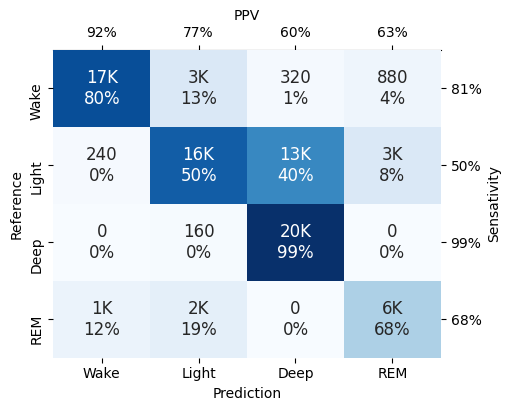

In [142]:
make_confusion_matrix(y_reference=sleep_labels, y_predicted=sleep_predictions,categories=['Wake', 'Light', 'Deep', 'REM'], figsize=(5, 4), cbar=False, title=False, sum_stats=False)
